In [36]:
pip install yfinance

In [37]:
import yfinance as yf # importing yfinance to get BTC Data

In [38]:
df = yf.download('BTC-USD') # creating the BTC dataframe

[*********************100%%**********************]  1 of 1 completed


In [39]:
import pandas as pd # importing the required libraries
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_error

**EDA**

In [40]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [41]:
df.shape # cheking the number of rows and columns present

(3577, 6)

In [42]:
df.info() # checking the data types of each column

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3577 entries, 2014-09-17 to 2024-07-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3577 non-null   float64
 1   High       3577 non-null   float64
 2   Low        3577 non-null   float64
 3   Close      3577 non-null   float64
 4   Adj Close  3577 non-null   float64
 5   Volume     3577 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 195.6 KB


In [43]:
df.isnull().sum() # checking for null values

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [44]:
df.describe() # checking the statistical summary of the data

,Open,High,Low,Close,Adj Close,Volume
count,3577.000000,3577.000000,3577.000000,3577.000000,3577.000000,3.577000e+03
mean,16885.763042,17271.657481,16473.994940,16901.749569,16901.749569,1.731038e+10
std,18778.765104,19204.184045,18312.000978,18789.729194,18789.729194,1.917711e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,1050.050049,1078.969971,1036.680054,1054.229980,1054.229980,2.493200e+08
50%,8852.120117,9062.415039,8668.705078,8845.830078,8845.830078,1.328112e+10
75%,27768.392578,28288.839844,27242.880859,27790.220703,27790.220703,2.788198e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11


In [45]:
df.duplicated().sum() # checking for duplicate values

0

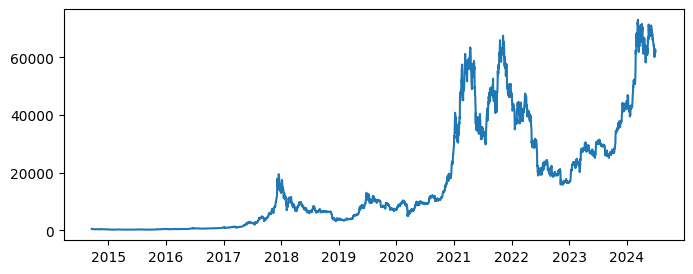

In [46]:
plt.plot(df.index, df['Close']) # plotting the closing price
plt.show()

**Checking for the stationarity**

The four had almost same behaviour troughout time and based on this assumption in this project we will only focus on one of them 'Close' in order to build a model which could predict future values and then as possible suggestions extrapolate such model to other indicators. Firstly, we will demonstrate if the time-series problem corresponds to a Non-Stationary type, which characterizes for having:

Non-constant variance./n Non-constant mean. Seasonality. High autocorrelation

There are four well known ways to evaluate if the serie meets the criteria just mentioned, these corresponds to:

Sequence visualization. Histogram, Autocorrelation and Partial Aurocorrelation plots. Statistical summary of chunks. Adfuller test

<Axes: >

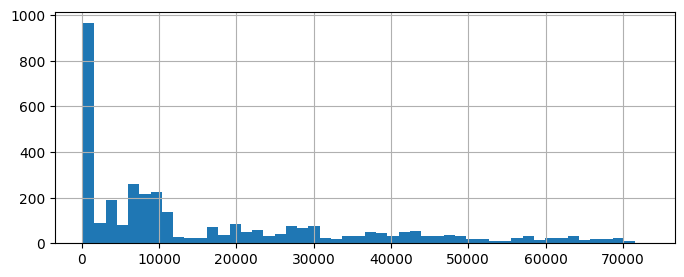

In [47]:

df['Close'].hist(bins=50) # plotting the histogram

We can't assume a uniform nor normal distribution in the plot above, because of that the statistical summary can helps us more, for this we will split the data into 10 chunks and compute mean and variance of each one.

In [48]:
chunk_size=np.round(df.shape[0]/10) # computing the number of rows in each chunk

In [49]:
import pandas as pd
from statistics import stdev

# Assuming df is your DataFrame and 'Close' is the column of interest
chunk_size = len(df) // 10  # Define chunk size as one-tenth of the DataFrame length

means = []
std_devs = []

# Loop through each chunk and calculate mean and standard deviation
for i in range(10):
    start_idx = int(i * chunk_size)
    end_idx = int((i + 1) * chunk_size)
    # Ensure the last chunk includes any remaining data
    if i == 9:
        end_idx = len(df)

    chunk = df['Close'].iloc[start_idx:end_idx]
    chunk_mean = chunk.mean()
    chunk_stdev = stdev(chunk)

    means.append(chunk_mean)
    std_devs.append(chunk_stdev)



In [50]:

pd.concat([pd.DataFrame(means,columns=['mean']),pd.DataFrame(std_devs,columns=['std'])], axis=1)

,mean,std
0,282.988423,58.614893
1,445.033476,128.334700
2,1433.939719,904.920791
3,8432.803361,3309.965627
4,6142.688567,2402.720746
5,8685.800981,1287.493557
6,31467.472120,17095.075507
7,42752.767261,11021.800236
8,22709.016227,4266.337389
9,46092.615637,16063.459565


Above we see how both measures are clearly different in each chunk. However looking at the plot we could assume a constant variance as the ripple in the curve, but without a doubt trend is the most outstanding feature. Until now can assume it's a non-stationary series, but to know more about it we will evaluate two other methods. Seasonal decomposition is a function from statsmodels library which allows us to decompose the series into trend, seasonal and residual, either additive or multiplicative:

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose # importing the seasonal decompose

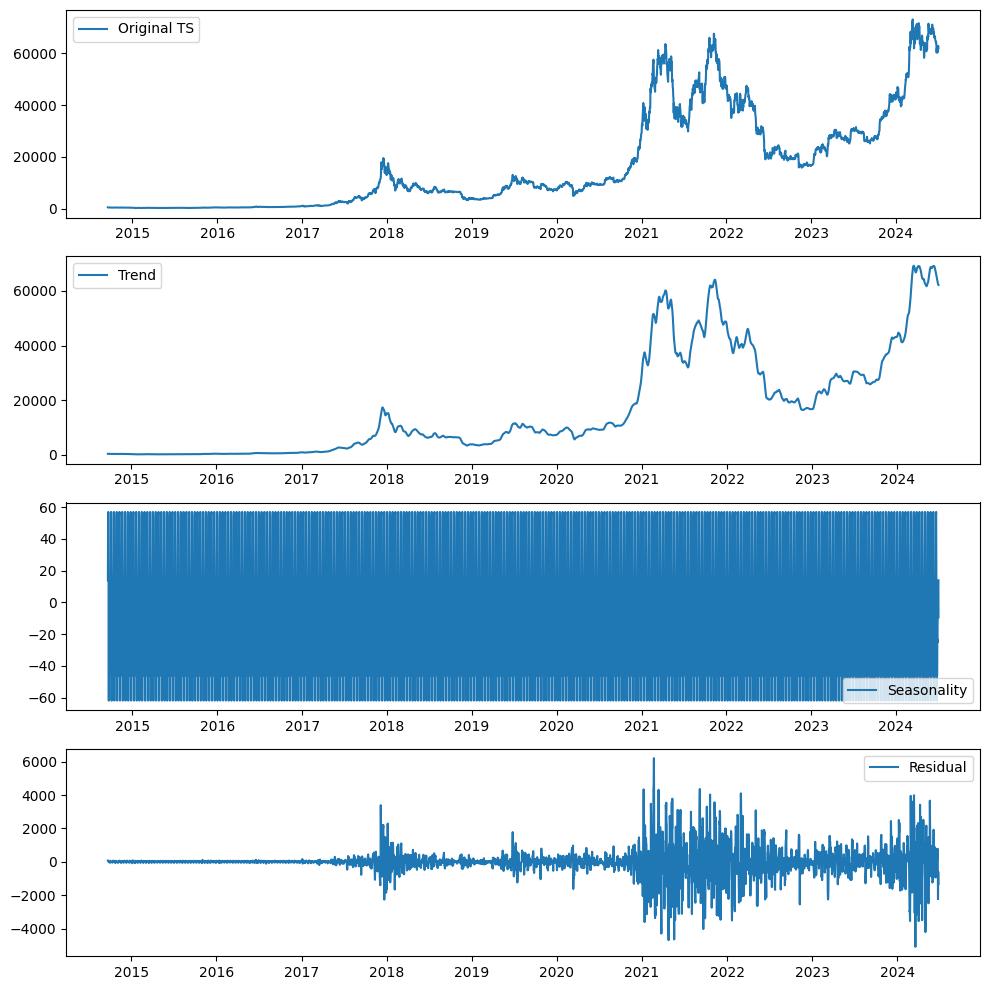

In [52]:
decompose_add=seasonal_decompose(df['Close'], model='additive', period=12) # additive seasonal decompose
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(df['Close'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

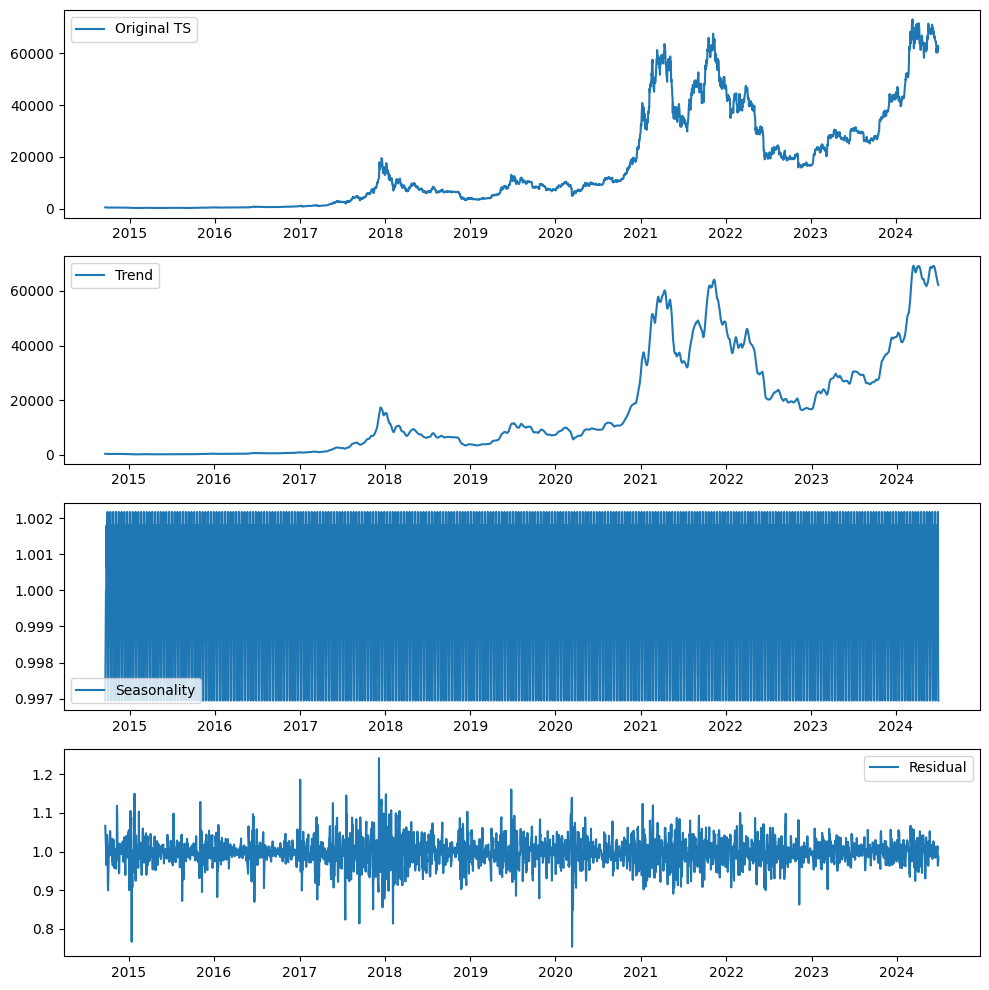

In [53]:

decompose_mul=seasonal_decompose(df['Close'], model='multiplicative', period=12) # multiplicative seasonal decompose
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(df['Close'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

Looking carefully to the original curve we can say the additive decomposition makes more sense as the trend does not seem to be changing by the multiplication with seasonal component, rather every component seems to being added up to create the original curve. Independent of this there is a trend and seasonal component.
Below we can see the ACF and PACF plots:

In [54]:
from statsmodels.graphics.tsaplots import plot_acf # importing the acf and pacf
from statsmodels.graphics.tsaplots import plot_pacf

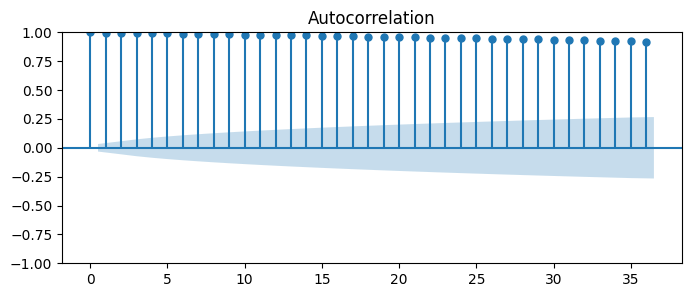

In [55]:
plt.rc("figure", figsize=(8,3)) # plotting the auto corelation
plot_acf(df['Close'])
print()

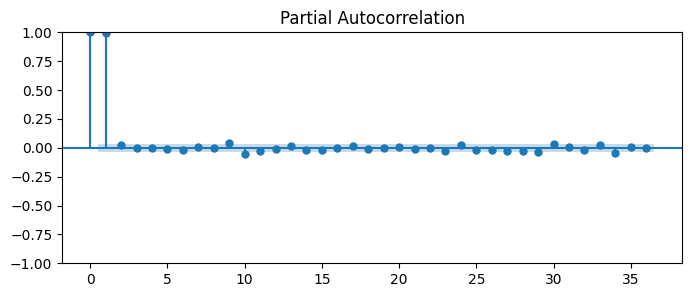

In [56]:
 plt.rc("figure", figsize=(8,3)) #plotting the partial auto co relation
plot_pacf(df['Close'])
print()

Finally, we will make the Augmented Dickey-Fuller test, using 5% as significance level and declaring the following hypothesis:

H0= Series corresponds to non-stationary type.
H1= Series corresponds to stationary type.

In [57]:
from statsmodels.tsa.stattools import adfuller # importing the adfuller

In [58]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.034471
p-value: 0.740485
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Applying differencing first

In [59]:
df['Close_Difference'] = df['Close'] - df['Close'].shift(1)

# Drop NaN values
df = df.dropna(subset=['Close_Difference'])

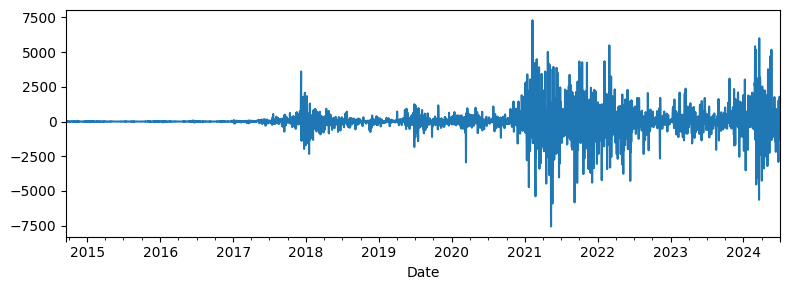

In [60]:
df['Close_Difference'].dropna().plot()
plt.tight_layout()

In [61]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on 'High_Difference' series
result = adfuller(df['Close_Difference'])

# Print out the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.292606
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


**Model Building (ARIMA)**

In [62]:
pip install pmdarima

In [63]:
from pmdarima import auto_arima # importing the auto arima

In [64]:
series = df['Close']

# Use auto_arima to find the best (p, d, q) values
model = auto_arima(series, seasonal=False, trace=True)

# Print the summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58419.030, Time=4.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58436.641, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58427.509, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=58427.796, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58436.083, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=58428.808, Time=3.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=58429.845, Time=4.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=58415.491, Time=15.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=58427.910, Time=5.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=58416.869, Time=17.71 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=58422.710, Time=4.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=58417.262, Time=8.71 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=58426.958, Time=2.41 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=58418.501, Time=11.33 sec
 ARIMA(3,1,2)(0,

In [65]:
df.sort_index(inplace=True)#sorting the index

In [66]:
# Train Test Split

to_row = int(len(df) * 0.9)
train_data = list(df[0:to_row]['Close'])
test_data = list(df[to_row:]['Close'])


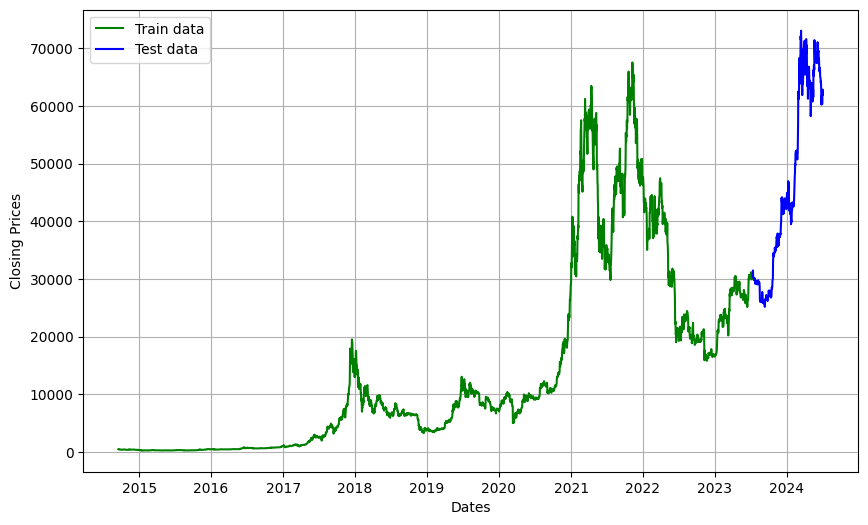

In [67]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df[0:to_row]['Close'],'green', label='Train data')
plt.plot(df[to_row:]['Close'],'blue', label='Test data')
plt.legend()

In [68]:
model_predictions =[]
n_test_ob = len(test_data)

In [69]:
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [70]:
for i in range(n_test_ob):
    model = ARIMA(train_data, order=(2,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = test_data[i]
    train_data.append(actual_test_value)

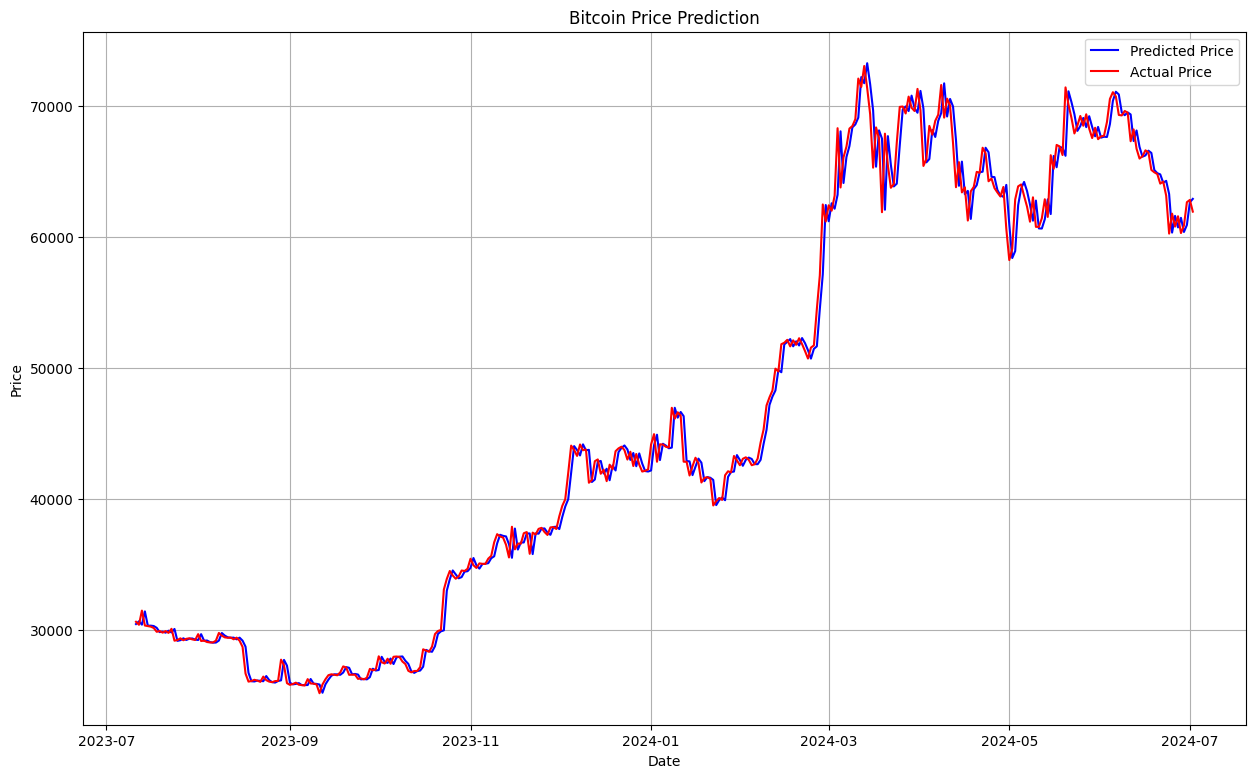

In [71]:
plt.figure(figsize=(15, 9))
plt.grid(True)


date_ran = df[to_row:].index
plt.plot(date_ran, model_predictions, color='blue', label='Predicted Price')
plt.plot(date_ran, test_data, color='red', label='Actual Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [72]:
mae = mean_absolute_error(test_data, model_predictions)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, model_predictions))

# Print MAE and RMSE
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 849.0092029460561
Root Mean Squared Error (RMSE): 1334.963233680843


In [73]:
results_df = pd.DataFrame({
    'Actual Values': test_data,
    'Predicted Values': model_predictions
})


In [74]:
results_df.t

,Actual Values,Predicted Values
0,30620.951172,30445.668733
1,30391.646484,30658.383469
2,31476.048828,30401.347608
3,30334.068359,31415.050214
4,30295.806641,30317.280502
...,...,...
353,60320.136719,61482.473788
354,60887.378906,60402.961109
355,62678.292969,60932.097046
356,62851.980469,62663.304753


**LSTM Predictions**

First we will scale our Train and Test Data

In [75]:
new_df =df['Close'].iloc[:-4]

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [77]:
#splitting data into training and testing
train_size = int(len(new_df)*0.8)
test_size = len(new_df) - train_size
training_data, testing_data = new_df[0:train_size,:], new_df[train_size:len(new_df),:]

In [78]:
# convert an array of values into datasets
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)


In [79]:
#reshape into X=t,t+1,t+2,t+3 and Y= T+4
time_step = 100
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(testing_data, time_step)

In [80]:
print(X_train.shape),print(y_train.shape)

(2756, 100)
(2756,)


(None, None)

In [81]:
print(X_test.shape),print(y_test.shape)

(614, 100)
(614,)


(None, None)

In [82]:
#reshape input[samples,times steps,features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [83]:
#create Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [84]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
44/44 [==============================] - 18s 221ms/step - loss: 0.0101 - val_loss: 0.0025
Epoch 2/100
44/44 [==============================] - 10s 232ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 3/100
44/44 [==============================] - 10s 218ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/100
44/44 [==============================] - 8s 177ms/step - loss: 8.8484e-04 - val_loss: 0.0011
Epoch 5/100
44/44 [==============================] - 9s 216ms/step - loss: 8.3874e-04 - val_loss: 0.0015
Epoch 6/100
44/44 [==============================] - 9s 204ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/100
44/44 [==============================] - 8s 186ms/step - loss: 7.1295e-04 - val_loss: 0.0012
Epoch 8/100
44/44 [==============================] - 9s 216ms/step - loss: 7.5176e-04 - val_loss: 0.0015
Epoch 9/100
44/44 [==============================] - 8s 194ms/step - loss: 7.6956e-04 - val_loss: 0.0012
Epoch 10/100
44/44 [==============================] - 9s 199ms/step 

In [87]:
# prediction and performance matrix
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


20/20 [==============================] - 1s 45ms/step


In [88]:
# Transform back to original
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [89]:
#calculate rmse performance matrix
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20882.189572535986

In [90]:
# Test Data Rmse
math.sqrt(mean_squared_error(y_test,test_predict))

39520.108765681565

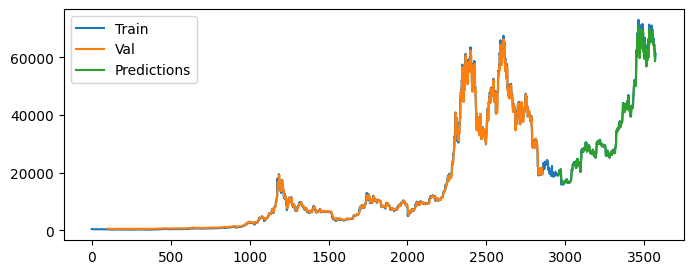

In [91]:
lookback = 100
# shift train prediction for plotting
trainPRredictPlot = np.empty_like(new_df)
trainPRredictPlot[:, :] = np.nan
trainPRredictPlot[lookback:len(train_predict)+lookback, :] = train_predict

# shift test prediction for plotting
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(new_df)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(new_df))
plt.plot(trainPRredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Train','Val','Predictions'])
plt.show()

In [135]:
len(testing_data)

715

In [121]:
# predict output for next 30 days
x_input = testing_data[615:].reshape(1,-1)
x_input.shape

(1, 100)

In [122]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [128]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
  if len(temp_input)>100:
    #print temp_input
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1, n_steps, 1))
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    #print temp_input
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape((1, n_steps,1))
    yhat = model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    i=i+1

print(lst_output)

0 day input [0.95714052 0.95753862 0.95023474 0.96792354 0.95623545 0.95284032
 0.97599833 0.95362001 0.89525429 0.90257666 0.93725216 0.92804566
 0.94256405 0.948962   0.98008185 0.94589585 0.9657691  0.95853681
 0.91924284 0.87295828 0.89925611 0.86753671 0.87282647 0.83805302
 0.86872376 0.87326138 0.88904719 0.88811726 0.91432979 0.90842617
 0.87920508 0.88201432 0.8720509  0.86743973 0.86324374 0.87322778
 0.82927677 0.79659272 0.80851807 0.86017957 0.87391842 0.87583406
 0.86391198 0.8525667  0.83683569 0.86237591 0.83141546 0.83142827
 0.84040817 0.86033886 0.84184009 0.90650887 0.89229991 0.91726778
 0.9157443  0.90665804 0.9775695  0.95957818 0.94566707 0.9293065
 0.93748887 0.94763687 0.93737904 0.94940093 0.93433571 0.92448561
 0.93527903 0.92329668 0.92625289 0.92686552 0.94131136 0.96549317
 0.97255787 0.96809103 0.94868811 0.94818317 0.95287718 0.95101571
 0.92111052 0.93358088 0.91321491 0.90299201 0.90545967 0.91160527
 0.90956495 0.89105397 0.88857885 0.88677321 0.8767

In [129]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [130]:
len(new_df)

3572

In [131]:
import matplotlib.pyplot as plt

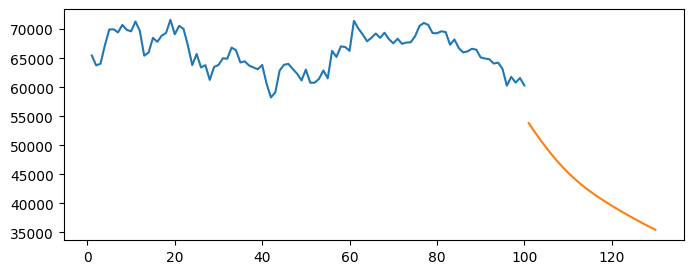

In [132]:
plt.plot(day_new,scaler.inverse_transform(new_df[3472:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

We have applied ARIMA (Machine Learning Model ) and LSTM (Deep Learning Model) to predict the Bitcoin 'Close' price. It can be seen that LSTM model gives us better accuracy than the ARIMA model.
Hence we can move ahead with LSTM predictions for predicting the price.